In [1]:
#| hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# | export
# | hide

# basic imports
from __future__ import annotations

# sys and paths imports
import json
import logging
import math
import os
import re
import sys
import warnings

# typing imports
from abc import ABC, abstractmethod
from dataclasses import dataclass
from datetime import datetime
from enum import Enum
from pathlib import Path
from random import randint
from time import sleep
from typing import Any, Generic, Literal

# cv and image imports
import cv2
import geopy
import imageio
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from dotenv import load_dotenv
from geopy.exc import GeocoderServiceError, GeocoderTimedOut
from geopy.geocoders import Nominatim

# widgets imports
from IPython.display import clear_output, display
from matplotlib.ticker import PercentFormatter
from PIL import Image as PImage
from pyproj import Geod
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import LineString
from tqdm.notebook import tqdm

from ds_contrib.core.files.structure import FSNode
from ds_contrib.core.paths import (
    Directory,
    PathLike,
    handle_existing,
    list_paths,
    pathify,
)

# visualization imports
from ds_contrib.core.plotting import plot
from ds_contrib.core.utils import Iterifiable, T, listify
from ds_contrib.tools.io.gscloud import GSBrowser, GSBrowserContext
from ds_contrib.tools.recslam.catalog import GSBrowserFileStructure

In [3]:
# | export
# | hide

os.environ["USE_PYGEOS"] = "0"
import geopandas as gpd

In [4]:
# | export
# | hide

logger = logging.getLogger(__name__)

## Recslam


In [5]:
# | hide

CWD = Path.cwd()
REPO_DIR = Path(*CWD.parts[: CWD.parts.index("ds_contrib") + 1])
CONFIGS_DIR = REPO_DIR / "configs"
ENV_DIR = CONFIGS_DIR / "env/local"

with open(CONFIGS_DIR / "storage/gscloud/projects_vars.json") as f:
    projects = json.load(f)

# choose project
project = projects["dev"]
env_path = Path(ENV_DIR / f'{project["env"]}_roadly.env')

_ = load_dotenv(env_path)  # read local .env file
google_app_creds = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")
roadly_cookie = os.getenv("ROADLY_COOKIE")

with open(CONFIGS_DIR / "storage/recslam/recslam_structure.json", "r") as f:
    RECSLAM_STRUCTURE = json.load(f)

print(f"Initial configuration has finished:\nProject: {project}")

Initial configuration has finished:
Project: {'project': 'roadly-project-dev', 'env': 'dev', 'coldline_name': 'standard'}


In [6]:
# | hide
GS_DATA_PATH = "roadly-dev-videos/Antalya/2022-02-21_13-18-38_4453/"
DOWNLOADS_ROOT_DIR = Directory(REPO_DIR / "data/dev", temporary=False)

Init GSBrowser and assert that `GS_DATA_PATH` exists


In [7]:
browser = GSBrowser(
    project=project["project"],
    credentials=google_app_creds,
    downloads_dir=DOWNLOADS_ROOT_DIR,
)
# Check that data exists
# RECSLAM_DATA_PATH must be a prefix and bucket to the root of recslam data
assert browser.is_present(GS_DATA_PATH), "Data is not present"

In [8]:
# Initialize GSBrowserFileStructure object and read necessary files
SESSION_DIR = Directory(
    DOWNLOADS_ROOT_DIR.path / "recslam" / Path(GS_DATA_PATH).name, temporary=False
)

dfs = GSBrowserFileStructure(
    browser,
    SESSION_DIR,
    CONFIGS_DIR / "storage/recslam/recslam_structure.json",
    GS_DATA_PATH,
)

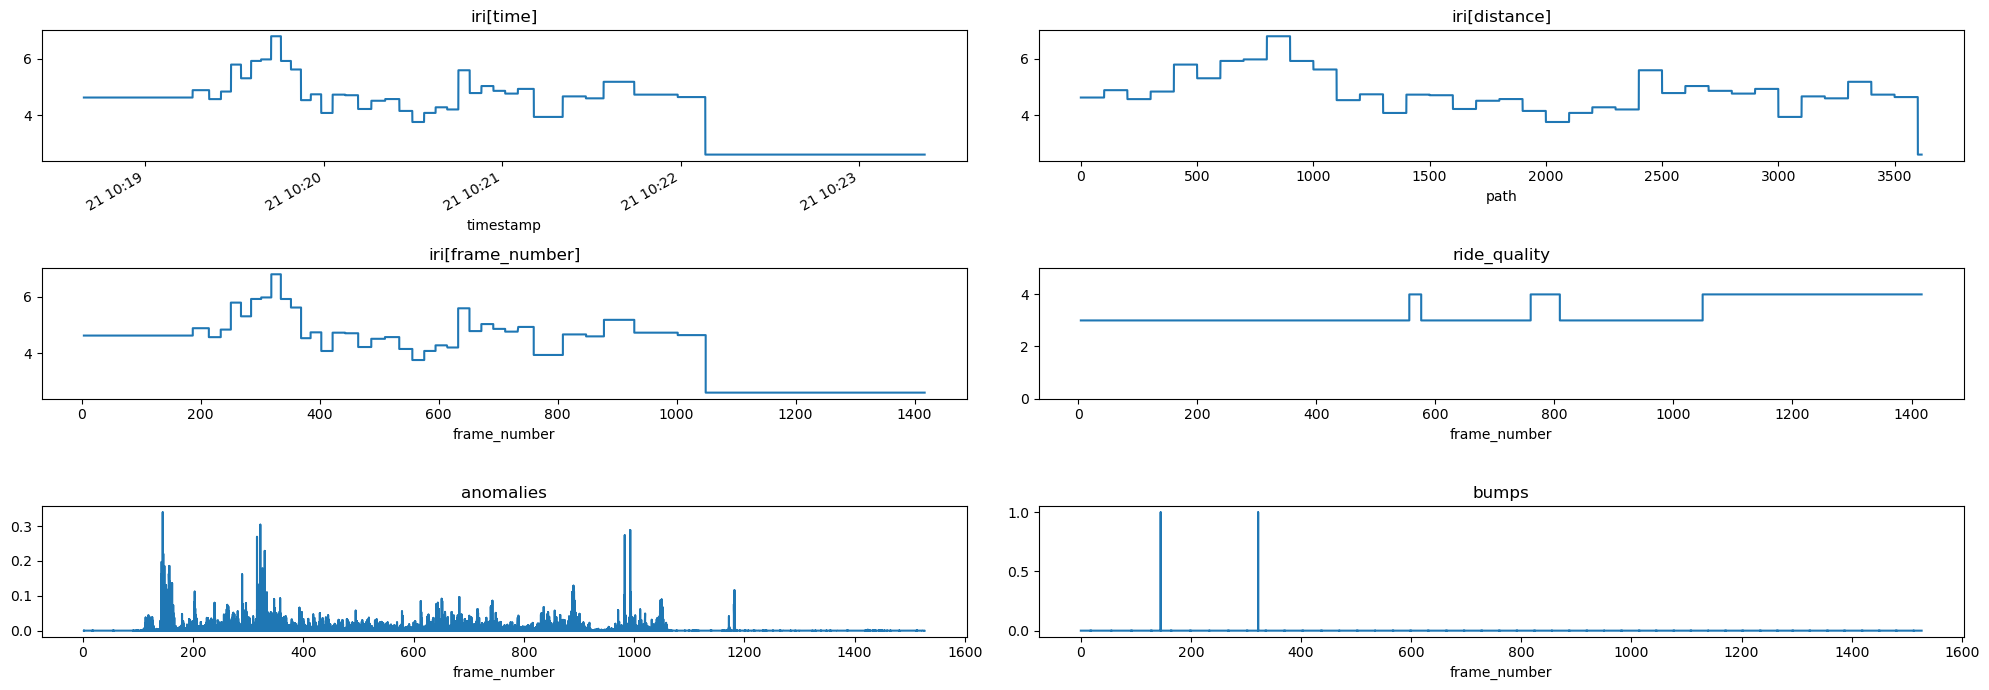

In [9]:
# Init download dir and GSBrowser
from ds_contrib.analysis.motion.iri import (
    plot_road_quality_on_range,
    plot_road_quality_stats,
    read_recslam_sensor_data_standard,
    road_quality_from_sensor_data,
)

# Read data
road_quality_dfs = read_recslam_sensor_data_standard(dfs)

# Calculate road quality
road_quality_data = road_quality_from_sensor_data(road_quality_dfs)

# Plot if necessary
plot_road_quality_stats(road_quality_data)

## Path-based frame sampler


In [10]:
road_quality_data

,frame_number,original_time_frames,source_frames,path,original_time_gps,source_gps,gps,path_progress,accel_x,original_time_imu,source_imu,section_number,rms,iri,ride_quality,rolling_accel_x,anomalies,bump
timestamp,,,,,,,,,,,,,,,,,,
2022-02-21 10:18:38.396164864,NaN,NaT,extrapolated,NaN,NaT,extrapolated,POINT EMPTY,NaN,-0.015159,2022-02-21 10:18:38.396164864,original,NaN,NaN,NaN,NaN,NaN,NaN,False
2022-02-21 10:18:38.406164864,NaN,NaT,extrapolated,NaN,NaT,extrapolated,POINT EMPTY,NaN,0.006758,2022-02-21 10:18:38.406178048,original,NaN,NaN,NaN,NaN,NaN,NaN,False
2022-02-21 10:18:38.416164864,NaN,NaT,extrapolated,NaN,NaT,extrapolated,POINT EMPTY,NaN,0.010176,2022-02-21 10:18:38.416190976,original,NaN,NaN,NaN,NaN,NaN,NaN,False
2022-02-21 10:18:38.426164864,NaN,NaT,extrapolated,NaN,NaT,extrapolated,POINT EMPTY,NaN,-0.008173,2022-02-21 10:18:38.426204928,original,NaN,NaN,NaN,NaN,NaN,NaN,False
2022-02-21 10:18:38.436164864,NaN,NaT,extrapolated,NaN,NaT,extrapolated,POINT EMPTY,NaN,-0.015287,2022-02-21 10:18:38.436218112,original,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-21 10:23:44.216164864,NaN,NaT,extrapolated,NaN,NaT,extrapolated,POINT EMPTY,NaN,-0.009866,2022-02-21 10:23:44.216288000,original,NaN,NaN,NaN,NaN,-0.003645,3.870554e-05,False
2022-02-21 10:23:44.226164864,NaN,NaT,extrapolated,NaN,NaT,extrapolated,POINT EMPTY,NaN,-0.004722,2022-02-21 10:23:44.226304000,original,NaN,NaN,NaN,NaN,-0.003719,1.006187e-06,False
2022-02-21 10:23:44.236164864,NaN,NaT,extrapolated,NaN,NaT,extrapolated,POINT EMPTY,NaN,0.000012,2022-02-21 10:23:44.236320000,original,NaN,NaN,NaN,NaN,-0.003594,1.300420e-05,False


In [11]:
def sample_frames_uniform_to_path(shared_index: pd.DataFrame, distance=3):
    df = shared_index.loc[:, ["path", "frame_number"]]
    df["section"] = df["path"] // distance
    df = df.groupby("section").first()
    df = df.groupby("frame_number").mean()
    df["distance"] = df["path"].diff()
    return df

In [12]:
sampled_frames = sample_frames_uniform_to_path(road_quality_data, distance=4)

In [13]:
sampled_frames

,path,distance
frame_number,,
4.0,0.000000,NaN
116.0,4.007025,4.007025
122.0,8.021256,4.014231
127.0,12.028426,4.007170
131.0,16.016548,3.988123
...,...,...
1049.0,3600.023784,3.967312
1052.0,3604.055171,4.031388
1057.0,3608.027120,3.971949


In [14]:
# TODO: refactor
from ds_contrib.core.data.video import IFramesSampler
from ds_contrib.core.data.video import get_video_metadata


class FrameSamplerPathBased(IFramesSampler):
    def __init__(
        self,
        video_metadata: dict,
        shared_index: pd.DataFrame,
        distance: float = 4,
        start_frame: int = 0,
        end_frame: int = None,
        max_frames: int = None,
        batch_size: int = None,
    ):
        # TODO[High](Bug): last frame is dropped
        sampled_frames = sample_frames_uniform_to_path(shared_index, distance=distance)
        frames_range = sampled_frames.index[
            (sampled_frames.index >= start_frame)
            & ((sampled_frames.index <= end_frame) if end_frame is not None else True)
        ]
        start_frame, end_frame = int(frames_range[0]), int(frames_range[-1])
        self._frames = frames_range.astype(int).values.tolist()
        max_frames = (
            min(len(frames_range), max_frames)
            if max_frames is not None
            else len(frames_range)
        )
        super().__init__(
            video_metadata,
            start_frame=start_frame,
            end_frame=end_frame,
            max_frames=max_frames,
            batch_size=batch_size,
        )

    def _next_frame_ind(self) -> int:
        return self._frames[self._frame_counter]

    @property
    def total_frames(self) -> int | None:
        return len(self._frames)

In [15]:
# | eval: false
dfs.get("camera_wide/video")
VIDEO_FILE = dfs["camera_wide/video"].meta["local_path"]

In [16]:
DISTANCE = 4
video_metadata = get_video_metadata(VIDEO_FILE)
fs = FrameSamplerPathBased(video_metadata, road_quality_data, distance=DISTANCE)

In [17]:
from ds_contrib.core.data.video import sample_frames_from_video


frames_dir = Directory(VIDEO_FILE.parent / f"frames_dist_{DISTANCE}", temporary=False)
# sample_frames_from_video(VIDEO_FILE, frames_dir, video_metadata, fs, with_catalog=True)

## Road Quality Widget


In [18]:
from ds_contrib.analysis.motion.iri import change_index
from ds_contrib.tools.widgets import IWidget, PaginationIterator


class RoadQualityWidget(IWidget):
    def __init__(
        self,
        road_quality_df: pd.DataFrame,
        range=100,
    ):
        """Road quality widget for a given sensor data

        It is possible to move forward and backward in the data and to move to a specific index
        It shows the road quality data for a given range around the current index, including:
        - iri
        - anomalies
        - bumps
        - path_progress
        Look at `plot_road_quality_on_range` for more details

        Parameters
        ----------
        sensor_data :  dict
            dictionary with motion, gps and timestamps dataframes
        initial_index : int, optional
            initial index, by default 0
        range : int, optional
            range of frames to show, by default 100
        """
        self._road_quality_df = change_index(road_quality_df, "frame_number")
        keys_collection = (
            self._road_quality_df.index.unique().dropna().astype(int).tolist()
        )
        self.pagination = PaginationIterator(
            keys_collection,
            range,
            start_index=0,
        )
        super().__init__()

    def _setup_gui(self):
        self._output = widgets.Output()  # create an Output widget
        self._widget = widgets.VBox([self._output])  # add the Output widget to a VBox

    def _cb_on_change_index(self, *args):
        self._render_index(self.pagination.page_keys_slice, self.pagination.current_key)

    def _attach_callbacks(self):
        # link internal pagination with frames pagination
        self.pagination.observe_index_changed(self._cb_on_change_index)

    def _render_index(self, range, index):
        with self._output:  # capture the output of the plot
            plt.close("all")  # This will close all active plots
            clear_output(wait=True)  # clear the previous output
            plot_road_quality_on_range(self._road_quality_df, range, index)

    def widgets(self, isolated=True):
        self._cb_on_change_index()
        return self._widget

In [19]:
frames_catalog = pd.read_csv(frames_dir.path / "frames_catalog.csv", index_col=0)
frames_catalog["absolute_path"] = frames_catalog["frame_path"].apply(
    lambda x: Path(frames_dir.path / x).absolute().resolve()
)

In [20]:
pagination = PaginationIterator(
    frames_catalog["absolute_path"].to_list(), 100, start_index=0, alignment="center"
)

In [21]:
# | eval: false

road_quality_widget = RoadQualityWidget(
    road_quality_data,
    range=100,
)

In [22]:
display(road_quality_widget.widgets())

In [23]:
# | eval: false
road_quality_widget.pagination.forward(10)

## Recslam Image Browser


In [24]:
from os import PathLike

from ds_contrib.tools.widgets import IStatusProvider, ImageBrowser


class RecslamImageBrowser(ImageBrowser):
    def __init__(
        self,
        image_paths: list[PathLike],
        images2frames_mapping: dict[PathLike, int],
        road_quality_data: pd.DataFrame,
        status_provider: IStatusProvider[T],
        start_index: int = 0,
    ) -> None:
        super().__init__(image_paths, status_provider, start_index)
        self._images2frames_mapping = images2frames_mapping
        self._road_quality_widget = RoadQualityWidget(
            road_quality_data,
            range=100,
        )
        self._road_quality_widget.pagination.link_to(
            self._pagination,
            reverse_mapping_func=lambda x: self._images2frames_mapping.get(x),
        )

    def widgets(self, isolated=True) -> widgets.Widget | dict[str, widgets.Widget]:
        self._cb_change_image()
        if isolated:
            return widgets.VBox(
                [
                    self.image_name_widget,
                    self.image_container,
                    self.status_bar.widgets(isolated=True),
                    self.change_status_widget.widgets(isolated=True),
                    self.pagination_widget.widgets(isolated=True),
                    self._road_quality_widget.widgets(isolated=True),
                ],
                layout=widgets.Layout(width="100%"),
            )

In [25]:
# | output: true
from ds_contrib.tools.widgets import DictStatusProvider, QAStatus


files = frames_catalog["absolute_path"].to_list()
path2frames_mapping = {
    v: k for k, v in frames_catalog["absolute_path"].to_dict().items()
}
status_provider = DictStatusProvider(
    {p: QAStatus.NOT_VIEWED for p in files}, list(QAStatus)
)

In [26]:
recslam_browser = RecslamImageBrowser(
    files, path2frames_mapping, road_quality_data, status_provider
)

In [27]:
display(recslam_browser.widgets(isolated=True))

---


## Under development


In [ ]:
# | export


class StatusStorage:
    _instance = None
    name: ClassVar[str] = "status"

    def __new__(cls):
        if cls._instance is None:
            cls._instance = super(StatusStorage, cls).__new__(cls)
            cls._instance.__init()
        return cls._instance

    def __init(self) -> None:
        # Connect to memcached server
        self.client = base.Client(("localhost", 11211))

    def key_generator(self, path: Path):
        return f"{self.name}:{str(path.absolute().resolve())}"

    def key_parser(self, key: str):
        return Path(key.split(":", 1)[1])

    def save_status(self, path: Path, status: BrowseStatus):
        self.client.set(self.key_generator(path), value=status.value)

    def load_status(self, path: Path) -> BrowseStatus | None:
        return BrowseStatus(self.client.get(self.key_generator(path)))

    def load_all_statuses(self, paths: Iterable[Path]) -> dict[Path, BrowseStatus]:
        return {
            self.key_parser(k): BrowseStatus(int(v))
            for k, v in self.client.get_multi(
                [self.key_generator(p) for p in paths]
            ).items()
        }

    def purge(self):
        self.client.flush_all()

    def dump(self):
        return self.client.stats()

    def close(self):
        self.client.close()
        self._instance = None

In [ ]:
# TODO: massive refactoring
class FileDialog(IWidget):
    def __init__(self, start_path=".", items_per_page=10):
        self.current_path = Path(start_path).absolute()
        self.items_per_page = items_per_page
        self.dir_pagination = None
        self.file_pagination = None

        super().__init__()
        self._init_css()
        self.navigate(self.current_path)

    def _setup_gui(self):
        self.output = widgets.Output()

    def _init_css(self):
        style = """
        <style>
            .custom-icon-color {
                text-align: right;
                width: 100%;
                display: flex;
                justify-content: space-between;
                align-items: center;
            }
            .custom-icon-color .fa {
                color: carbon;
                margin-right: 10px; /* Adjust as necessary */
            }
        </style>
        """
        display(HTML(style))

    def get_sorted_items(self):
        all_items = list(self.current_path.iterdir())
        directories = sorted(
            [item for item in all_items if item.is_dir()], key=lambda x: x.name.lower()
        )
        files = sorted(
            [item for item in all_items if item.is_file()], key=lambda x: x.name.lower()
        )
        return directories, files

    def navigate(self, path):
        self.current_path = path
        directories, files = self.get_sorted_items()
        self.dir_pagination = PaginationIterator(
            directories, self.items_per_page, start_index=0, alignment="left"
        )
        self.file_pagination = PaginationIterator(
            files, self.items_per_page, start_index=0, alignment="left"
        )
        with self.output:
            self.output.clear_output()
            display(self.create_file_dialog())

    def _create_file_button(self, file: Path, type="file"):
        icon = "file" if type == "file" else "folder"
        btn = widgets.Button(
            description=file.name, icon=icon, layout=widgets.Layout(width="100%")
        )
        # Create a button with an icon
        btn.add_class("custom-icon-color")
        btn.on_click(self.on_file_click)
        return btn

    def _create_dir_column(self, directories: list[Path]):
        dir_current_items = self.dir_pagination.page_keys
        dir_list = [
            self._create_file_button(f, type="dir")
            for f in directories
            if f in dir_current_items
        ]

        up_button = widgets.Button(icon="arrow-up", layout=widgets.Layout(width="40px"))
        up_button.on_click(self.on_up_click)

        choose_folder_button = widgets.Button(
            icon="plus", layout=widgets.Layout(width="40px")
        )
        choose_folder_button.on_click(self.on_choose_folder_click)

        dir_prev_button = widgets.Button(
            icon="arrow-left", layout=widgets.Layout(width="40px")
        )
        dir_prev_button.on_click(self.on_dir_prev_click)
        dir_prev_button.disabled = not self.dir_pagination.has_previous_page(
            self.items_per_page, unique=True
        )

        dir_next_button = widgets.Button(
            icon="arrow-right", layout=widgets.Layout(width="40px")
        )
        dir_next_button.on_click(self.on_dir_next_click)
        # dir_next_button.disabled = not self.dir_pagination.has_next_page(
        #     self.items_per_page, unique=True
        # )
        dir_navigation_buttons = widgets.HBox(
            [dir_prev_button, dir_next_button, up_button, choose_folder_button],
            layout=widgets.Layout(width="50%"),
        )
        dir_slice = self.dir_pagination.page_inds_slice
        dir_header = widgets.HBox(
            [
                widgets.Text(
                    value=f"[{len(self.dir_pagination)}]: {self.current_path.name} | ({dir_slice.start+1}:{dir_slice.stop})",
                    disabled=True,
                    layout=widgets.Layout(width="50%"),
                ),
                dir_navigation_buttons,
            ],
            layout=widgets.Layout(width="100%"),
        )
        dir_list_box = widgets.VBox(
            [dir_header, *dir_list],
            layout=widgets.Layout(width="30%", overflow_y="auto"),
        )
        return dir_list_box

    def _create_files_column(self, files: list[Path]):
        file_current_items = self.file_pagination.page_keys
        file_list = [
            self._create_file_button(f) for f in files if f in file_current_items
        ]

        file_prev_button = widgets.Button(
            icon="arrow-left", layout=widgets.Layout(width="40px")
        )
        file_prev_button.on_click(self.on_file_prev_click)
        file_prev_button.disabled = not self.file_pagination.has_previous_page(
            self.items_per_page, unique=True
        )

        file_next_button = widgets.Button(
            icon="arrow-right", layout=widgets.Layout(width="40px")
        )
        file_next_button.on_click(self.on_file_next_click)
        # file_next_button.disabled = not self.file_pagination.has_next_page(
        #     self.items_per_page, unique=True
        # )

        file_navigation_buttons = widgets.HBox(
            [file_prev_button, file_next_button], layout=widgets.Layout(width="40%")
        )

        file_header = widgets.HBox(
            [
                widgets.Text(
                    value="Files", disabled=True, layout=widgets.Layout(width="100%")
                ),
                file_navigation_buttons,
            ],
            layout=widgets.Layout(width="100%"),
        )
        file_list_box = widgets.VBox(
            [file_header, *file_list],
            layout=widgets.Layout(width="40%", overflow_y="auto"),
        )
        return file_list_box

    def create_file_dialog(self):
        directories, files = self.get_sorted_items()
        dir_list_box = self._create_dir_column(directories)
        file_list_box = self._create_files_column(files)
        return widgets.HBox([dir_list_box, file_list_box])

    def on_choose_folder_click(self, btn):
        self._notify_dir_click(self.current_path)

    def on_dir_prev_click(self, btn):
        self.dir_pagination.backward(self.items_per_page)
        with self.output:
            self.output.clear_output()
            display(self.create_file_dialog())

    def on_dir_next_click(self, btn):
        self.dir_pagination.forward(self.items_per_page)
        with self.output:
            self.output.clear_output()
            display(self.create_file_dialog())

    def on_file_prev_click(self, btn):
        self.file_pagination.backward(self.items_per_page)
        with self.output:
            self.output.clear_output()
            display(self.create_file_dialog())

    def on_file_next_click(self, btn):
        self.file_pagination.forward(self.items_per_page)
        with self.output:
            self.output.clear_output()
            display(self.create_file_dialog())

    def on_file_click(self, btn):
        selected_path = self.current_path / btn.description
        if selected_path.is_dir():
            self.navigate(selected_path)
        else:
            self._notify_file_click(selected_path)

    def on_up_click(self, btn):
        parent_path = self.current_path.parent
        self.navigate(parent_path)

    def observe_on_file_click(self, observer_cb: Callable[[Path], Any]):
        self._observers["file_click"].append(observer_cb)

    def observe_on_dir_click(self, observer_cb: Callable[[Path], Any]):
        self._observers["dir_click"].append(observer_cb)

    def _notify_file_click(self, path: Path):
        for observer_cb in self._observers["file_click"]:
            observer_cb(path)

    def _notify_dir_click(self, path: Path):
        for observer_cb in self._observers["dir_click"]:
            observer_cb(path)

    def widgets(self, isolated=True):
        return self.output

    def close(self):
        self.output.close()

In [ ]:
# Usage
file_dialog = FileDialog(items_per_page=10)
file_dialog.observe_on_file_click(lambda x: print(f"File clicked: {x}"))
file_dialog.observe_on_dir_click(lambda x: print(f"Dir clicked: {x}"))

HTML(value='\n        <style>\n            .custom-icon-color {\n                text-align: right;\n         …

Dir clicked: /Users/arseniy/Projects/dev/ds_contrib/nbs/tools


In [ ]:
display(file_dialog.widgets(isolated=True))

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': "HBox(children=(VBox(children=(HBox(chi…

In [ ]:
file_dialog.close()

In [ ]:
# | export


class FolderLoader(IWidget):
    def __init__(self, default_folder: Path | None = None) -> None:
        self._folder = Path(default_folder) if default_folder else Path.cwd()
        self._file_dialog = None
        super().__init__()

    def _setup_gui(self):
        self.button = widgets.Button(description="Open Folder")
        self.button.on_click(self.select_folder)
        self.folder_name_widget = widgets.Text(
            value=f"`{str(self._folder)}`",
            description="Current directory",
            disabled=True,
            layout=widgets.Layout(width="100%"),
        )

    @property
    def folder(self):
        return self._folder

    def _set_folder(self, folder: Path):
        self._folder = folder
        self.folder_name_widget.value = f"`{str(self._folder)}`"
        self._file_dialog.close()

    def files(self, pattern=r".*\.(jpg|jpeg|png)$", recursive=False):
        files: Iterable[Path] = [
            p.absolute().resolve()
            for p in list_paths(self.folder, pattern=pattern, recursive=recursive)
        ]
        files: list[Path] = list(sorted(files, key=lambda x: int(x.stem)))
        return files

    def select_folder(self, button):
        self._file_dialog = FileDialog(self.folder)
        self._file_dialog.observe_on_dir_click(lambda p: self._set_folder(p))
        display(file_dialog.widgets(isolated=True))

    def widgets(self, isolated=True):
        # Display the button in the notebook
        return widgets.HBox([self.button, self.folder_name_widget])

In [ ]:
# | output: true
image_folder = Path("../../dev_notebooks/data/images/")
fl = FolderLoader(image_folder)
display(fl.widgets(), clear=True)

In [ ]:
fl.files()

[Path('/Users/arseniy/Projects/dev/ds_contrib/dev_notebooks/data/images/717.png'),
 Path('/Users/arseniy/Projects/dev/ds_contrib/dev_notebooks/data/images/720.png'),
 Path('/Users/arseniy/Projects/dev/ds_contrib/dev_notebooks/data/images/725.png'),
 Path('/Users/arseniy/Projects/dev/ds_contrib/dev_notebooks/data/images/726.png'),
 Path('/Users/arseniy/Projects/dev/ds_contrib/dev_notebooks/data/images/729.png'),
 Path('/Users/arseniy/Projects/dev/ds_contrib/dev_notebooks/data/images/731.png'),
 Path('/Users/arseniy/Projects/dev/ds_contrib/dev_notebooks/data/images/733.png'),
 Path('/Users/arseniy/Projects/dev/ds_contrib/dev_notebooks/data/images/735.png'),
 Path('/Users/arseniy/Projects/dev/ds_contrib/dev_notebooks/data/images/741.png'),
 Path('/Users/arseniy/Projects/dev/ds_contrib/dev_notebooks/data/images/762.png'),
 Path('/Users/arseniy/Projects/dev/ds_contrib/dev_notebooks/data/images/764.png'),
 Path('/Users/arseniy/Projects/dev/ds_contrib/dev_notebooks/data/images/766.png'),
 Pat